<a href="https://colab.research.google.com/github/jamagiwa/Kaggle/blob/main/GSE131928_PCA_analysis.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#有名データのGSE131928を解析してみる


###おまじない

In [38]:
!pip install anndata scanpy
!pip install leidenalg
!pip install igraph
!pip install gseapy
!pip install gcsfs
!pip install adjustText

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import anndata as ad
import scanpy as sc
import gseapy as gp
import matplotlib.patches as mpatches
import os
import gcsfs
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from numpy import trapz
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import FastICA
%matplotlib inline

###ダウンロードは一回だけでいい

In [14]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE131nnn/GSE131928/suppl/GSE131928_RAW.tar -O GSE131928_RAW.tar
#ファイルを解凍する
!tar -xvf GSE131928_RAW.tar

--2025-09-11 10:12:08--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE131nnn/GSE131928/suppl/GSE131928_RAW.tar
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.13, 130.14.250.31, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 669112320 (638M) [application/x-tar]
Saving to: ‘GSE131928_RAW.tar’

GSE131928_RAW.tar   100%[===================>] 638.12M  24.9MB/s    in 18s     

2025-09-11 10:12:27 (34.8 MB/s) - ‘GSE131928_RAW.tar’ saved [669112320/669112320]

GSM3828672_Smartseq2_GBM_IDHwt_processed_TPM.tsv.gz
GSM3828673_10X_GBM_IDHwt_processed_TPM.tsv.gz


In [15]:
#pandasでTPM値のテーブルデータを読み込む(すでにノーマライズ済み)
file_path = 'GSM3828673_10X_GBM_IDHwt_processed_TPM.tsv.gz'

# sep='\t'でタブ区切りを指定, index_col=0で最初の列(遺伝子名)をインデックスに設定
tpm_df = pd.read_csv(file_path, sep='\t', index_col=0, compression='gzip')

#adataを自力で作成
#pandas DataFrameは (遺伝子 x 細胞) の形なので、転置(.T)して (細胞 x 遺伝子) の形にする
adata = ad.AnnData(tpm_df.T)

adata.var_names_make_unique()

print(adata)

AnnData object with n_obs × n_vars = 16201 × 30314


##PCAで展開

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(
/tmp/ipython-input-272903623.py:20: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_fil, resolution=0.5)


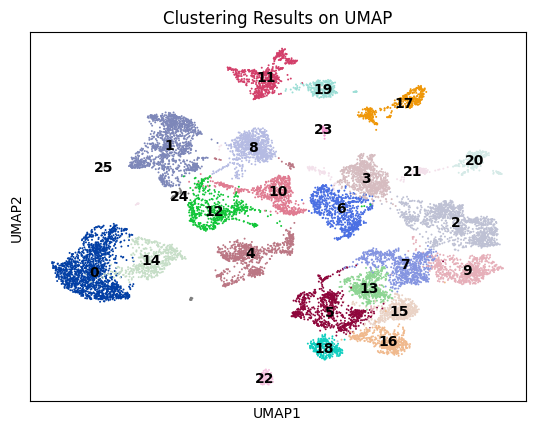

In [19]:
adata_fil = adata.copy()

# --- フィルタリング ---
sc.pp.filter_genes(adata_fil, min_cells=3)
sc.pp.filter_cells(adata_fil, min_genes=200)

# --- 正規化と対数変換 ---
sc.pp.normalize_total(adata_fil, target_sum=1e4)
sc.pp.log1p(adata_fil)

# --- 変動遺伝子の特定 ---
sc.pp.highly_variable_genes(adata_fil, min_mean=0.0125, max_mean=3.0, min_disp=0.5)

# --- PCAの実行 (変動遺伝子のみを対象) ---
sc.pp.pca(adata_fil, n_comps=50, use_highly_variable=True) # ★変動遺伝子のみを使うことで、より安定した結果が得られます

# --- 近傍グラフ計算、UMAP、Leidenクラスタリング ---
sc.pp.neighbors(adata_fil, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_fil)
sc.tl.leiden(adata_fil, resolution=0.5)

# --- クラスタリング結果の可視化 ---
sc.pl.umap(adata_fil, color='leiden', legend_loc='on data', title='Clustering Results on UMAP')


/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:456: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

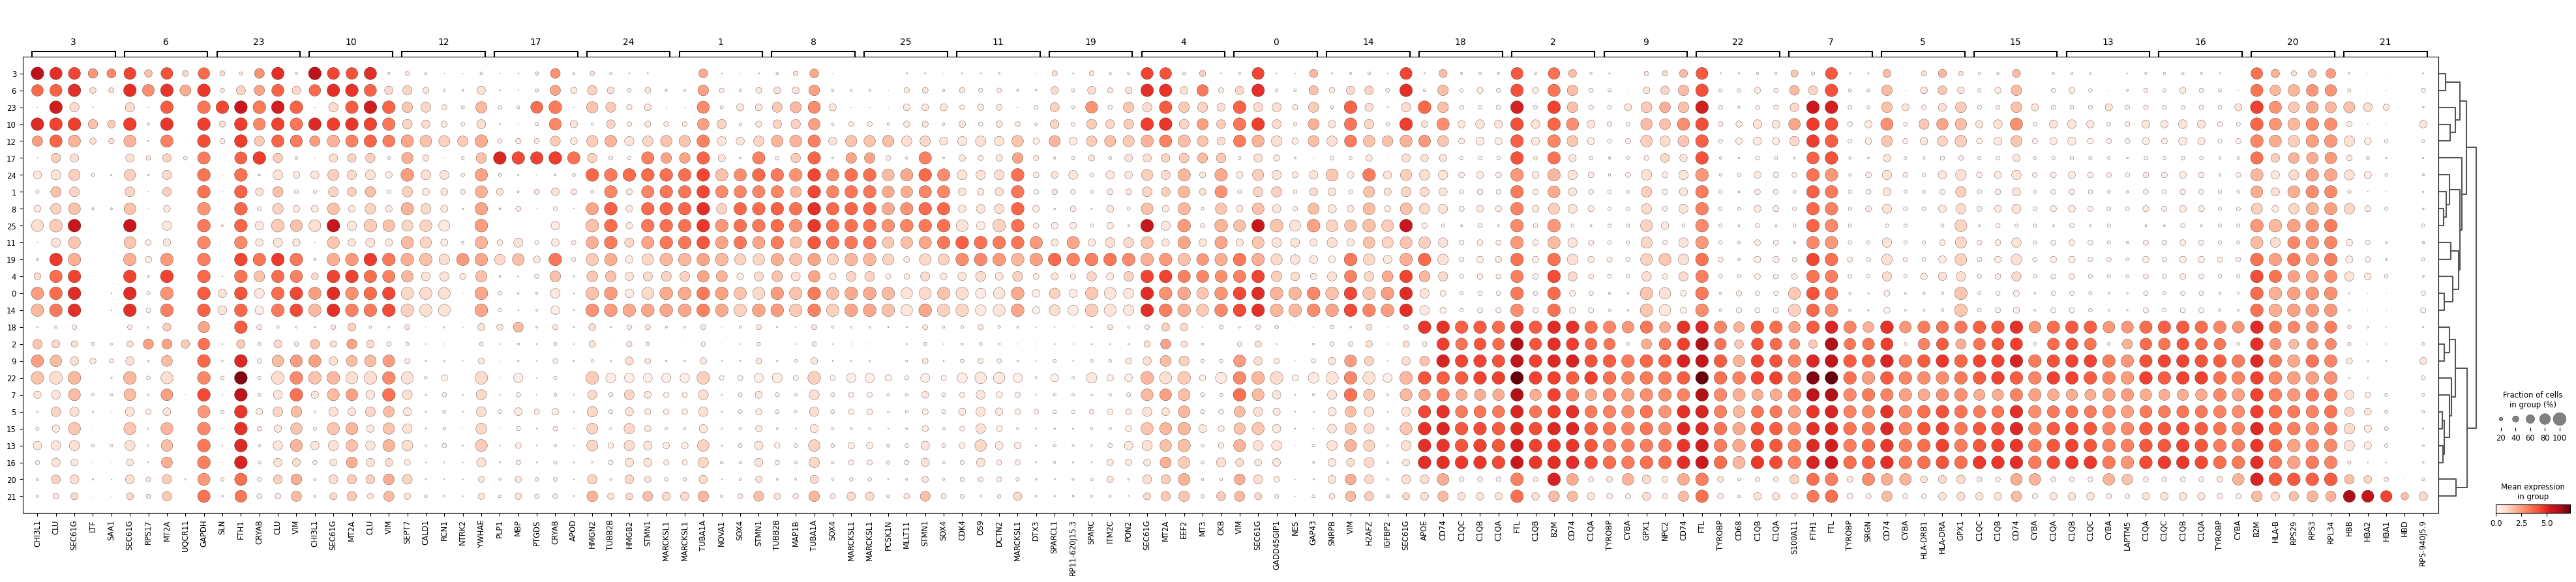

GO解析結果（0）:
                     Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   

                                                Term Overlap   P-value  \
0            glial cell differentiation (GO:0010001)    4/29  0.000013   
1  positive regulation of leukocyte migration (GO...    4/29  0.000013   
2  positive regulation of epithelial cell prolife...   6/123  0.000036   
3  positive regulation of cell migration (GO:0030...   8/269  0.000062   
4  regulation of production of miRNAs involved in...    3/18  0.000094   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.007660            0                     0   33.125000   
1          0.007660            0                     0   33.125000   
2          0.014322            0                     0   10.792690   
3          0.018625            0                     0    6.54306

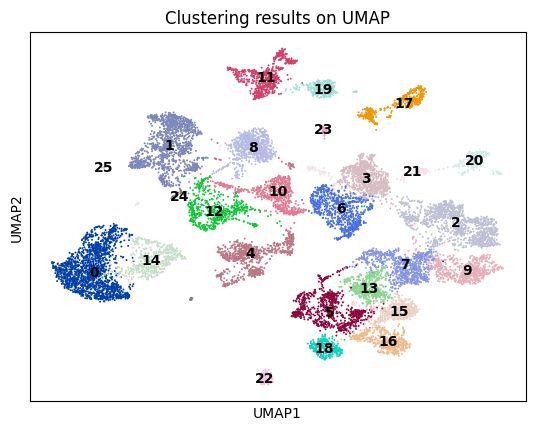

In [20]:
#Leidenクラスタリングを行う、自動的に類似細胞をグループ化してくれる
#グループ名は0, 1, 2とラベル付けされる

#遺伝子名の重複を解消する
adata_fil.var_names_make_unique()

sc.tl.leiden(adata_fil, resolution=0.5)

#マーカー遺伝子の特定
sc.tl.rank_genes_groups(adata_fil,
                        'leiden',
                        method = 't-test')

#結果をプロット
sc.pl.rank_genes_groups_dotplot(adata_fil, n_genes=5)

#各クラスターのマーカー遺伝子リストを取得する
# 'rank_genes_groups' の結果は adata_fil.uns['rank_genes_groups'] に保存されているらしい
results = adata_fil.uns['rank_genes_groups']
groups = results['names'].dtype.names

#各グループに対して解析を実行する
for group in groups:
 # 上位マーカー遺伝子リストを取得する
    gene_list = results['names'][group][:100].tolist()

    # 出力ディレクトリを作成
    output_dir_go = f'go_enrichment_{group}'
    output_dir_kegg = f'kegg_enrichment_{group}'
    os.makedirs(output_dir_go, exist_ok=True)
    os.makedirs(output_dir_kegg, exist_ok=True)

    # GO（Gene Ontology）解析
    go_enrichment = gp.enrichr(gene_list=gene_list,
                                gene_sets=['GO_Biological_Process_2021'],
                                organism='Human', # 生物種に応じて変更
                                outdir=output_dir_go,
                                no_plot=True) # プロットを生成しない

    # 結果をCSVファイルに保存
    if go_enrichment.results is not None and not go_enrichment.results.empty:
        go_enrichment.results.to_csv(f"{output_dir_go}/{group}_go_results.csv", index=False)
        print(f"GO解析結果（{group}）:")
        print(go_enrichment.results.head())
    else:
        print(f"GO解析結果（{group}）: 結果が見つかりませんでした。")


    # KEGGパスウェイ解析
    kegg_enrichment = gp.enrichr(gene_list=gene_list,
                                 gene_sets=['KEGG_2021_Human'],
                                 organism='Human', # 生物種に応じて変更
                                 outdir=output_dir_kegg,
                                 no_plot=True) # プロットを生成しない

    # 結果をCSVファイルに保存
    if kegg_enrichment.results is not None and not kegg_enrichment.results.empty:
        kegg_enrichment.results.to_csv(f"{output_dir_kegg}/{group}_kegg_results.csv", index=False)
        print(f"KEGGパスウェイ解析結果（{group}）:")
        print(kegg_enrichment.results.head())
    else:
        print(f"KEGGパスウェイ解析結果（{group}）: 結果が見つかりませんでした。")

print(f"KEGGパスウェイ解析結果（{group}）:")
print(kegg_enrichment.results.head())

#leidenクラスタリング上と同じ位相グラフを利用
#各細胞の二次元上の配置を計算
sc.tl.umap(adata_fil)

#UMAPを描画


# legend_loc='on data' にすると、凡例の代わりに各クラスターのかたまりに直接番号が表示され、見やすくなる。
sc.pl.umap(
    adata_fil,
    color = 'leiden',
    legend_loc = 'on data',
    frameon = True, #プロットの枠線をなくす
    title = 'Clustering results on UMAP'
)


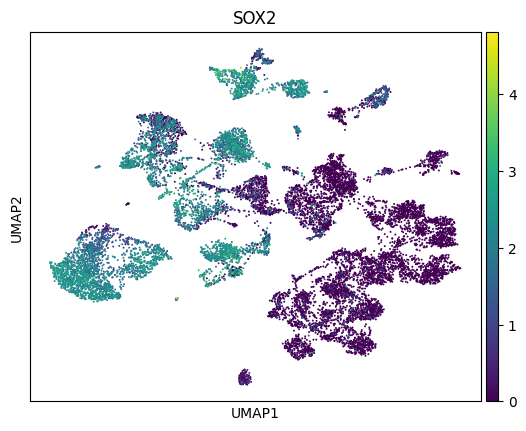

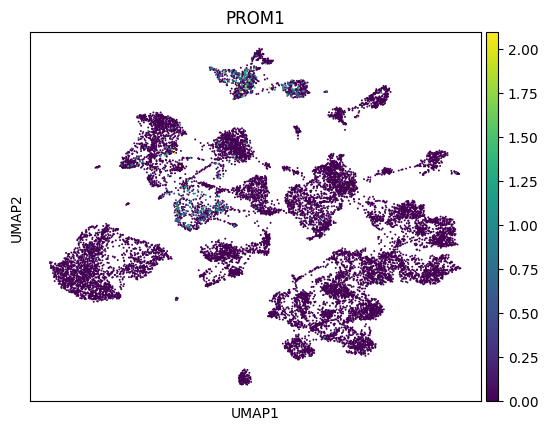

In [21]:
sc.pl.umap(adata_fil, color = 'SOX2', title = 'SOX2', frameon = True)
sc.pl.umap(adata_fil, color = 'PROM1', title = 'PROM1', frameon = True)


In [22]:
# --- 新しいAnnDataオブジェクトからpca_dfを作成 ---
# このセルを実行する前に、あなたの新しいデータが
# `adata_fil` という変数名で読み込まれていることを確認してください。

pca_df = pd.DataFrame(adata_fil.obsm['X_pca'][:, :2], columns=['PC1', 'PC2'], index=adata_fil.obs.index)
pca_df['leiden'] = adata_fil.obs['leiden']

print("--- pca_dfの準備が完了しました ---")
display(pca_df.head())

--- pca_dfの準備が完了しました ---


,PC1,PC2,leiden
102_1,-6.408566,-6.345872,1
102_2,-6.909505,-5.704144,1
102_4,-5.003955,-8.097865,1
102_5,-6.922873,-4.705439,1
102_7,-6.445922,-7.507404,1


/tmp/ipython-input-579670993.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', n_clusters)
/tmp/ipython-input-579670993.py:69: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  asymmetry_score = trapz(np.abs(imag_part), t)
/tmp/ipython-input-579670993.py:70: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  coherence_score = trapz(real_part, t)
/tmp/ipython-input-579670993.py:69: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  asymmetry_score = trapz(np.abs(imag_part), t)
/tmp/ipython-input-579670993.py:70: Depr

--- 計算結果サマリー ---


/tmp/ipython-input-579670993.py:69: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  asymmetry_score = trapz(np.abs(imag_part), t)
/tmp/ipython-input-579670993.py:70: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  coherence_score = trapz(real_part, t)


,mean,mode,asymmetry_score,coherence_score,dominant_frequency,Label
0,"[-8.25852, 2.895037]","[-8.958144, 3.1844857]",1.632328,-0.058295,1.496250,Cluster 0
1,"[-6.2675595, -6.048483]","[-6.445922, -7.507404]",1.652576,0.041582,0.997500,Cluster 1
2,"[8.863203, 0.6271189]","[12.024124, 0.18409474]",0.550428,-0.000487,1.496250,Cluster 2
3,"[-2.673815, 6.4074416]","[-2.4879782, 6.38477]",1.493519,0.069076,0.498750,Cluster 3
4,"[-5.7137938, 1.3362433]","[-6.7477837, 1.252255]",1.047136,0.021973,0.997500,Cluster 4
5,"[10.9351425, -1.8961173]","[11.582733, -1.9086944]",1.123582,-0.013337,1.745625,Cluster 5
6,"[-4.568161, 6.2029905]","[-4.504199, 4.052578]",1.014304,0.025906,0.748125,Cluster 6
7,"[7.815545, 1.3527409]","[8.845653, 1.142291]",0.759219,0.007357,1.246875,Cluster 7
8,"[-6.520986, -7.9593573]","[-6.983829, -8.210293]",1.689010,0.041148,0.997500,Cluster 8
9,"[11.935129, 0.8460597]","[13.10537, 0.51369524]",0.846915,-0.000742,1.995000,Cluster 9


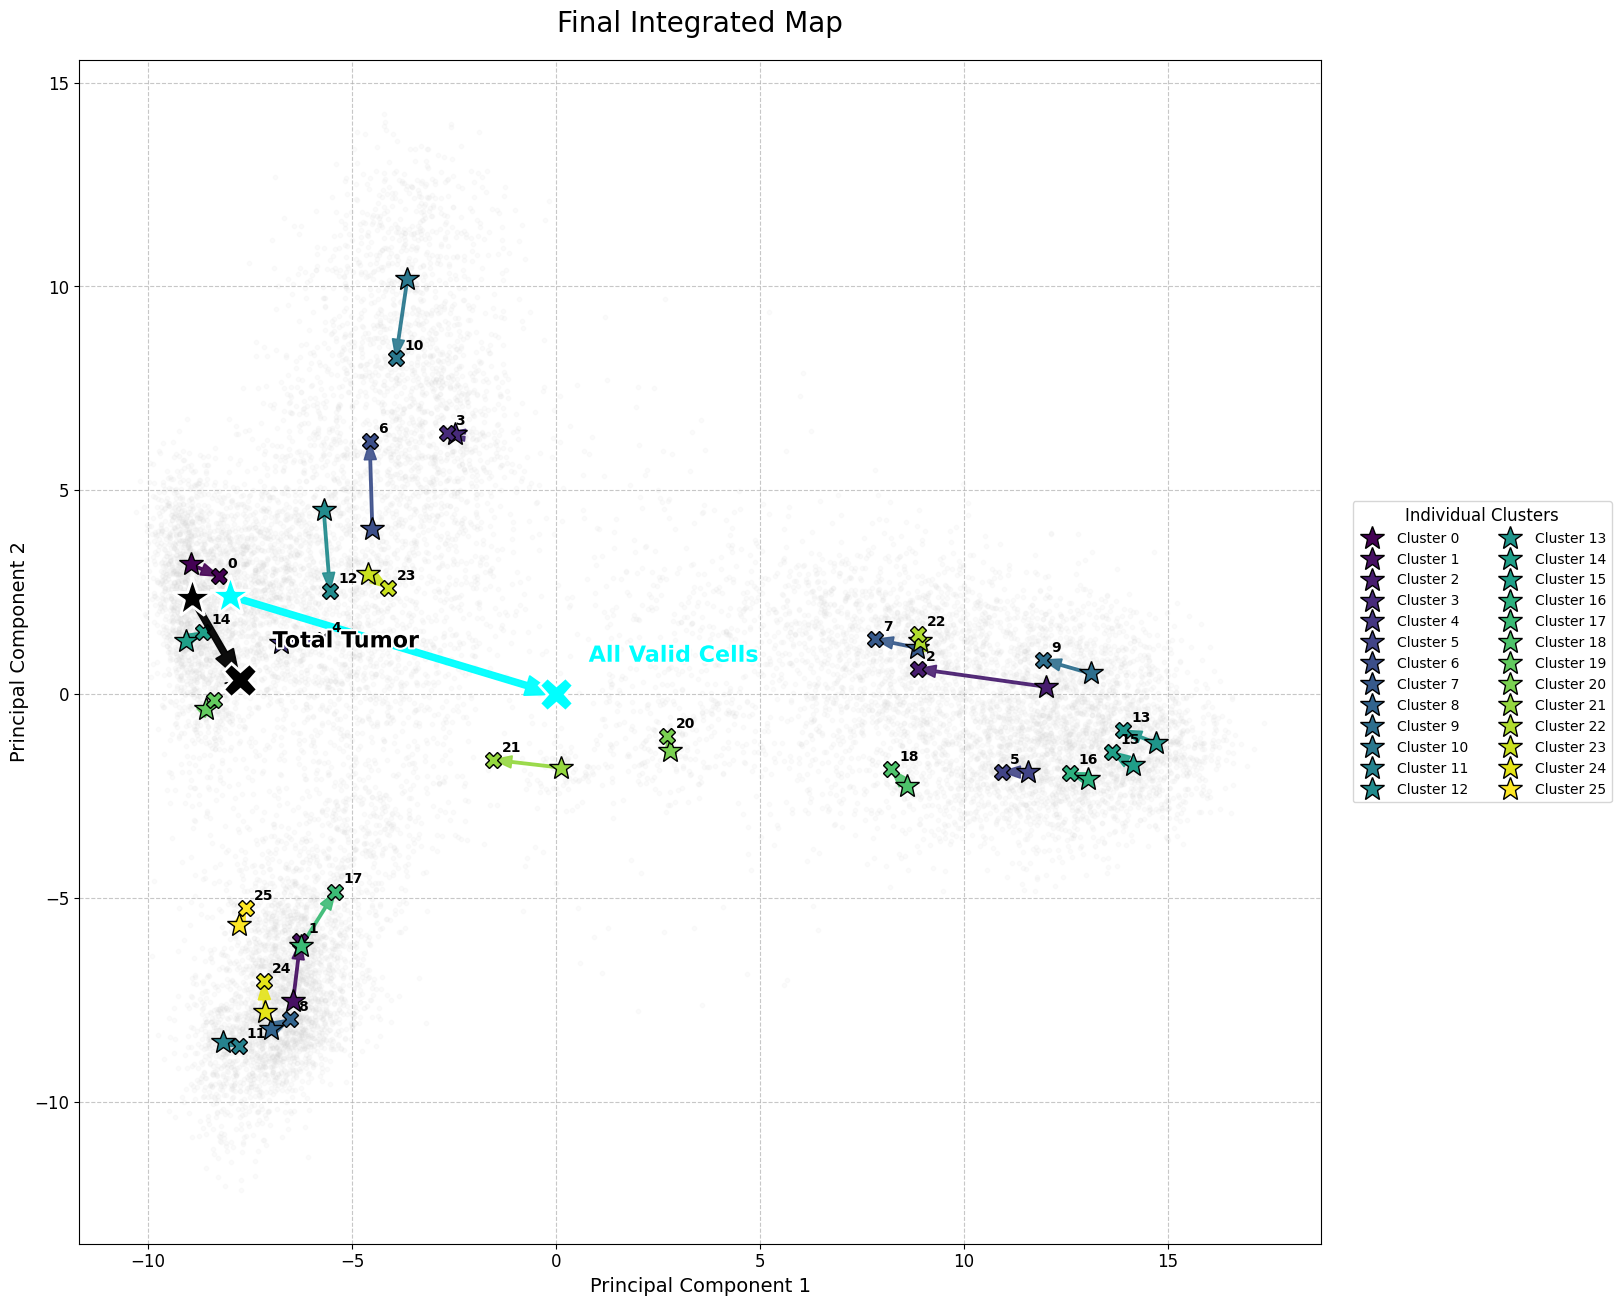

In [23]:
# ==============================================================================
# セットアップと定義 (編集版)
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np

# --- ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★ ---
# --- ★ ここから、あなたの新しいデータセットに合わせて編集しました ★ ---
# --- ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★ ---

# 解析対象としたい個別クラスターのIDをリストとして定義 (0から25)
individual_clusters = [str(i) for i in range(26)]

# 腫瘍細胞に対応するクラスターIDを定義
tumor_clusters = ['0', '11', '12', '14', '24', '25']

# --- グラフ用のカラーマップを自動生成 ---
# クラスター数が多いので、matplotlibのカラーマップから26色を自動的に生成します
# 'viridis' や 'tab20b', 'tab20c' など、他のカラーマップも試せます
n_clusters = 26
colors = plt.cm.get_cmap('viridis', n_clusters)
color_map = {str(i): colors(i / n_clusters) for i in range(n_clusters)}
# サマリー用のグループの色を追加
color_map['Tumor_Total'] = 'black'
color_map['All_Cells'] = 'cyan'

# --- グラフ用のラベルを自動生成 ---
labels_map = {str(i): f'Cluster {i}' for i in range(n_clusters)}
# サマリー用のグループのラベルを追加
labels_map['Tumor_Total'] = 'Total Tumor'
labels_map['All_Cells'] = 'All Valid Cells'

# --- ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★ ---
# --- ★ 編集はここまでです ★ ---
# --- ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★ ---

all_groups_to_analyze = individual_clusters + ['Tumor_Total', 'All_Cells']
total_tumor_df = pca_df[pca_df['leiden'].isin(tumor_clusters)]
all_cells_df = pca_df[pca_df['leiden'].isin(individual_clusters)]

# ==============================================================================
# 全指標の計算
# ==============================================================================
from scipy.stats import gaussian_kde
from numpy import trapz
from sklearn.preprocessing import MinMaxScaler

all_metrics = {}

def calculate_ecf_parts(data, t_range=(-2, 2), n_points=400):
    t = np.linspace(t_range[0], t_range[1], n_points)
    ecf_matrix = np.exp(1j * np.outer(data, t))
    ecf = np.mean(ecf_matrix, axis=0)
    return t, np.real(ecf), np.imag(ecf)

for group_id in all_groups_to_analyze:
    if group_id == 'Tumor_Total': current_df = total_tumor_df
    elif group_id == 'All_Cells': current_df = all_cells_df
    else: current_df = pca_df[pca_df['leiden'] == group_id]

    coords, pc1_data = current_df[['PC1', 'PC2']].values, current_df['PC1'].values
    mean_vec = np.mean(coords, axis=0)
    if len(coords) > 1:
        kde = gaussian_kde(coords.T)
        mode_vec = coords[np.argmax(kde.evaluate(coords.T))]
    else: mode_vec = mean_vec

    t, real_part, imag_part = calculate_ecf_parts(pc1_data)
    asymmetry_score = trapz(np.abs(imag_part), t)
    coherence_score = trapz(real_part, t)

    fft_result = np.fft.fft(imag_part)
    power_spectrum = np.abs(fft_result)**2
    frequencies = np.fft.fftfreq(len(t), d=(t[1]-t[0]))
    dominant_frequency = frequencies[frequencies > 0][np.argmax(power_spectrum[frequencies > 0])]

    all_metrics[group_id] = {
        'mean': mean_vec, 'mode': mode_vec, 'asymmetry_score': asymmetry_score,
        'coherence_score': coherence_score, 'dominant_frequency': dominant_frequency
    }

summary_df = pd.DataFrame.from_dict(all_metrics, orient='index')
summary_df['Label'] = summary_df.index.map(labels_map)
print("--- 計算結果サマリー ---"); display(summary_df)

# ==============================================================================
# 主要なグラフの描画
# ==============================================================================
# ==============================================================================
# 改良版 A. 背景プロット付きベクトルマップ
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np
# ★★★ パスエフェクトのライブラリをインポート ★★★
import matplotlib.patheffects as pe

fig, ax = plt.subplots(figsize=(18, 16))

# --- 1. 背景となる細胞の散布図をプロット ---
ax.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.08, s=10, c='lightgray', zorder=0)

# --- 2. 各クラスターのModeとMeanをプロット (個別クラスター) ---
for group_id in individual_clusters:
    metrics = all_metrics[group_id]
    color = color_map.get(group_id, 'gray')

    ax.plot(metrics['mode'][0], metrics['mode'][1], '*', c=color, markersize=18, markeredgecolor='black', mew=1, zorder=3, label=labels_map.get(group_id))
    ax.plot(metrics['mean'][0], metrics['mean'][1], 'X', c=color, markersize=12, markeredgecolor='black', mew=1, zorder=3)

    ax.arrow(x=metrics['mode'][0], y=metrics['mode'][1],
             dx=metrics['mean'][0] - metrics['mode'][0],
             dy=metrics['mean'][1] - metrics['mode'][1],
             color=color, head_width=0.3, width=0.06,
             length_includes_head=True, alpha=0.9, zorder=2)

    ax.text(metrics['mean'][0] + 0.2, metrics['mean'][1] + 0.2,
            f'{group_id}', fontsize=10, color='black', fontweight='bold', zorder=4)

# --- 3. 全体的なグループ（Total Tumor, All Cells）の強調表示 ---
for group_id in ['Tumor_Total', 'All_Cells']:
    metrics = all_metrics[group_id]
    color = color_map.get(group_id, 'black')

    ax.plot(metrics['mode'][0], metrics['mode'][1], '*', c=color, markersize=30, markeredgecolor='white', mew=2, zorder=4)
    ax.plot(metrics['mean'][0], metrics['mean'][1], 'X', c=color, markersize=25, markeredgecolor='white', mew=2, zorder=4)

    ax.arrow(x=metrics['mode'][0], y=metrics['mode'][1],
             dx=metrics['mean'][0] - metrics['mode'][0],
             dy=metrics['mean'][1] - metrics['mode'][1],
             color=color, head_width=0.5, width=0.15,
             length_includes_head=True, alpha=0.95, zorder=3)

    # ★★★ path_effectsの呼び出し方を pe.withStroke に修正 ★★★
    ax.text(metrics['mean'][0] + 0.8, metrics['mean'][1] + 0.8,
            labels_map.get(group_id), fontsize=16, color=color, fontweight='bold',
            path_effects=[pe.withStroke(linewidth=3, foreground="white")], zorder=5)

# --- 4. グラフの見た目を整える ---
ax.set_title('Final Integrated Map', fontsize=20, pad=20)
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_aspect('equal', adjustable='box')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

handles, labels = ax.get_legend_handles_labels()
unique_labels = {}
for h, l in zip(handles, labels):
    if l.startswith('Cluster'):
        unique_labels[l] = h

plt.legend(unique_labels.values(), unique_labels.keys(),
           loc='center left', bbox_to_anchor=(1.02, 0.5),
           ncol=2, title="Individual Clusters", fontsize=10, title_fontsize=12)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

なんとなく傾向はある気がする

# ICAを行う

--- ICAを実行しています... ---
--- ICAの計算が完了しました ---
--- ica_dfの準備が完了しました ---


,IC1,IC2,leiden
102_1,-1.204204,-0.518030,1
102_2,1.514774,-2.060245,1
102_4,-0.648589,0.572669,1
102_5,0.537296,-0.306414,1
102_7,0.080200,1.240620,1


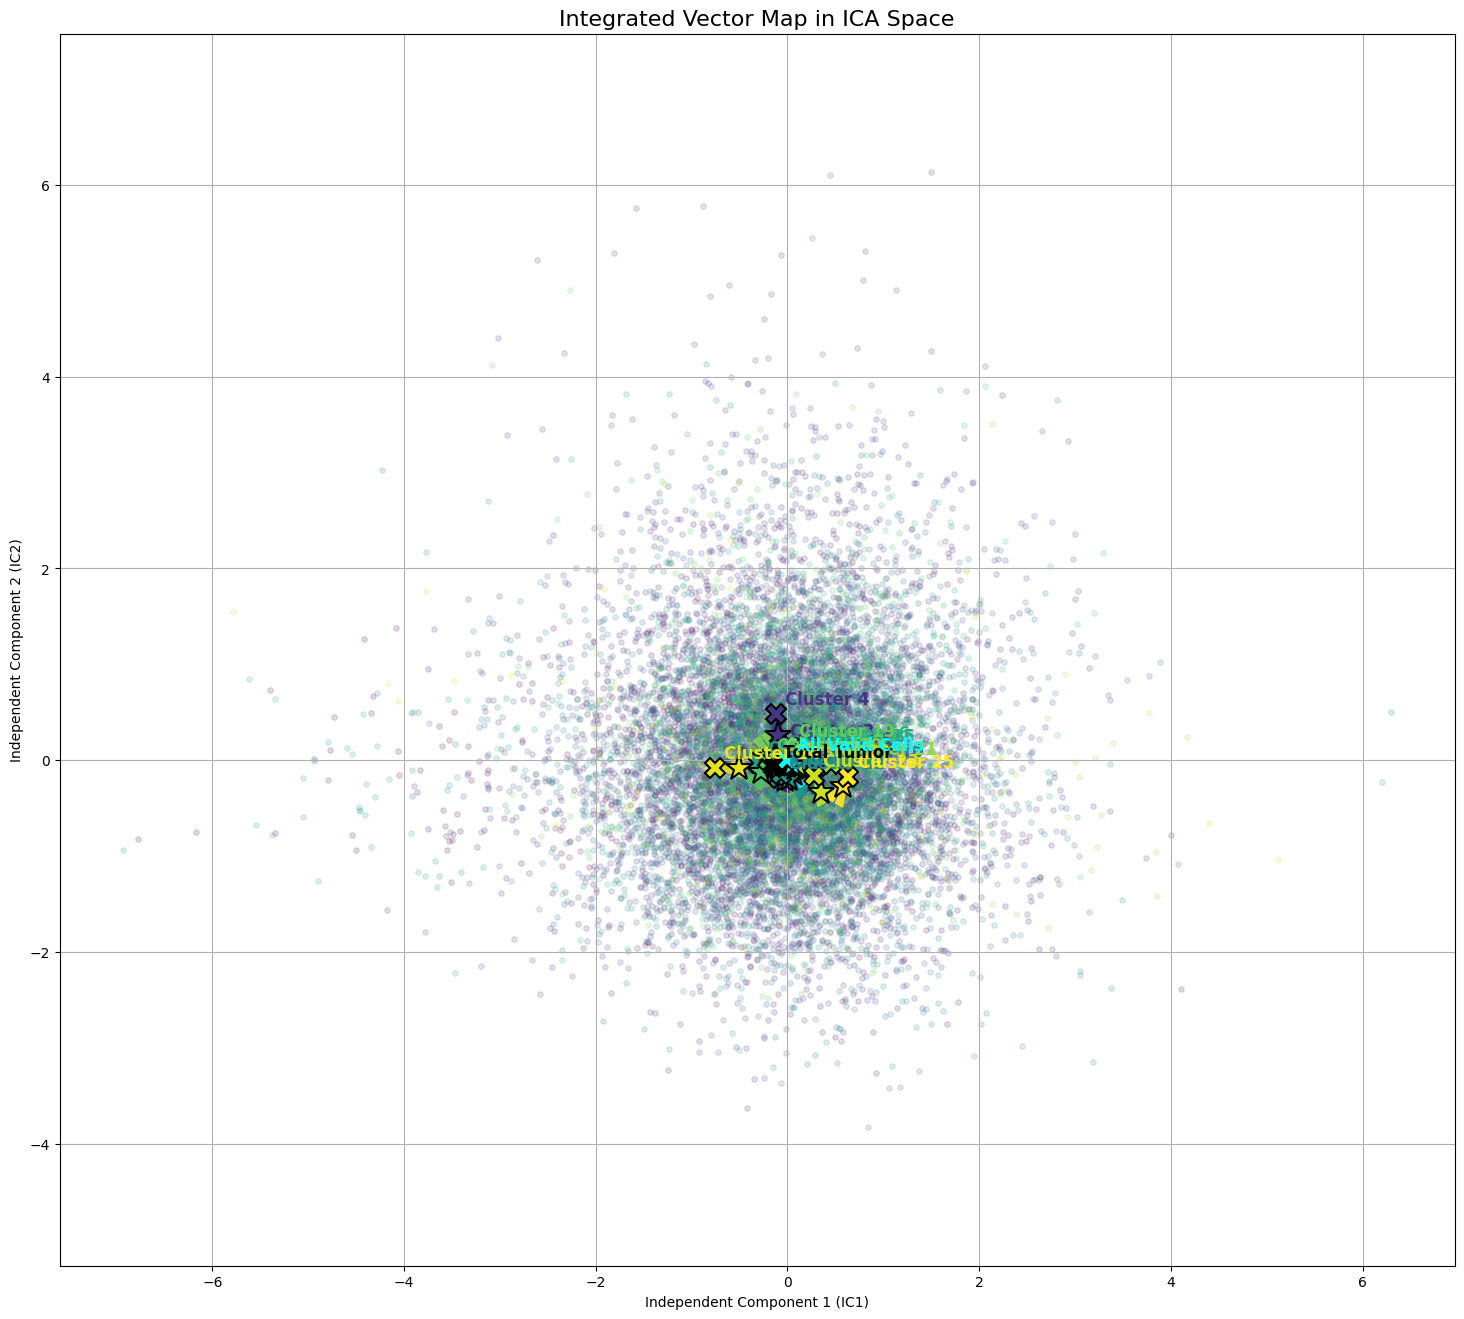

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
from sklearn.decomposition import FastICA # ★★★ scikit-learnからFastICAをインポート ★★★

# --- ★★★ 1. scikit-learnを使ってICAを実行 ★★★ ---
print("--- ICAを実行しています... ---")

# a) ICAモデルを準備
# n_componentsはPCAで指定した数と合わせ、random_stateで結果を固定
ica_model = FastICA(n_components=50, random_state=0)

# b) PCAの結果を元にICAを計算
# 通常、ICAはノイズが少ないPCAの結果に対して適用します
ica_results = ica_model.fit_transform(adata_fil.obsm['X_pca'])

# c) 計算結果をAnnDataオブジェクトに格納
adata_fil.obsm['X_ica'] = ica_results

print("--- ICAの計算が完了しました ---")


# --- 2. ICAの結果を用いてDataFrameを作成 ---
# この部分以降は、前回と全く同じコードで動作します
ica_df = pd.DataFrame(adata_fil.obsm['X_ica'][:, :2], columns=['IC1', 'IC2'], index=adata_fil.obs.index)
ica_df['leiden'] = adata_fil.obs['leiden']

print("--- ica_dfの準備が完了しました ---")
display(ica_df.head())


# --- 3. プロットに必要な変数を準備 ---
tumor_clusters = ['0', '11', '12', '14', '24', '25']
n_clusters = ica_df['leiden'].astype(int).max() + 1
individual_clusters_ica = [str(i) for i in range(n_clusters)]
groups_to_plot_ica = individual_clusters_ica + ['Tumor_Total', 'All_Cells']

# all_metrics_ica を計算
all_metrics_ica = {}
for group_id in individual_clusters_ica:
    cluster_df = ica_df[ica_df['leiden'] == group_id]
    if not cluster_df.empty:
        all_metrics_ica[group_id] = {
            'mean': (cluster_df['IC1'].mean(), cluster_df['IC2'].mean()),
            'mode': (cluster_df['IC1'].median(), cluster_df['IC2'].median())
        }
# (以降のメトリクス計算、カラーマップ生成、プロット処理は前回と同じです)
# 'Tumor_Total'のメトリクスを計算
tumor_df = ica_df[ica_df['leiden'].isin(tumor_clusters)]
all_metrics_ica['Tumor_Total'] = {
    'mean': (tumor_df['IC1'].mean(), tumor_df['IC2'].mean()),
    'mode': (tumor_df['IC1'].median(), tumor_df['IC2'].median())
}
# 'All_Cells'のメトリクスを計算
all_metrics_ica['All_Cells'] = {
    'mean': (ica_df['IC1'].mean(), ica_df['IC2'].mean()),
    'mode': (ica_df['IC1'].median(), ica_df['IC2'].median())
}
# カラーマップとラベルを生成
colors = plt.get_cmap('viridis', n_clusters)
color_map = {str(i): colors(i) for i in range(n_clusters)}
labels_map = {str(i): f'Cluster {i}' for i in range(n_clusters)}
color_map['Tumor_Total'] = 'black'
color_map['All_Cells'] = 'cyan'
labels_map['Tumor_Total'] = 'Total Tumor'
labels_map['All_Cells'] = 'All Valid Cells'


# --- 4. プロット処理 ---
fig, ax = plt.subplots(figsize=(18, 16))
# (プロット処理の中身は前回と同じなので省略)
for cluster_id in individual_clusters_ica:
    cluster_df = ica_df[ica_df['leiden'] == cluster_id]
    ax.scatter(cluster_df['IC1'], cluster_df['IC2'],
               alpha=0.15, s=15, c=[color_map.get(cluster_id)])
for group_id in groups_to_plot_ica:
    if group_id in all_metrics_ica:
        metrics = all_metrics_ica[group_id]
        color = color_map.get(group_id)
        ax.plot(metrics['mode'][0], metrics['mode'][1], '*', c=color, markersize=20, markeredgecolor='black', mew=1.5)
        ax.plot(metrics['mean'][0], metrics['mean'][1], 'X', c=color, markersize=15, markeredgecolor='black', mew=1.5)
        ax.arrow(
            x=metrics['mode'][0], y=metrics['mode'][1],
            dx=metrics['mean'][0] - metrics['mode'][0],
            dy=metrics['mean'][1] - metrics['mode'][1],
            color=color, head_width=0.2, width=0.03, length_includes_head=True,
            alpha=0.9
        )
        ax.text(metrics['mean'][0] + 0.1, metrics['mean'][1] + 0.1, f'{labels_map.get(group_id, group_id)}',
                fontsize=12, color=color, fontweight='bold')


# --- 5. グラフの見た目を整える ---
ax.set_title('Integrated Vector Map in ICA Space', fontsize=16)
ax.set_xlabel('Independent Component 1 (IC1)')
ax.set_ylabel('Independent Component 2 (IC2)')
ax.grid(True)
ax.axis('equal')
plt.show()